<a href="https://colab.research.google.com/github/fcastellanosp/MINE-4206_202510_AML/blob/main/Laboratorios/Laboratorio_5/MINE_4206_202510_AML_Lab5_S1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

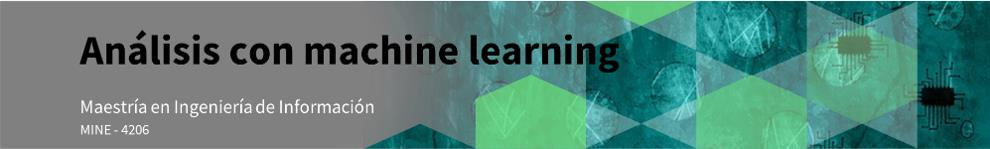

**Tutores**.
* Nicolás Tibatá Casteñeda.
* Fabián Camilo Castellanos P.

#Tabla de contenido

[Contexto y objetivos.](#scrollTo=IR2JC8BLooAn)<br>
[0. Instalación e importación de librerías.](#scrollTo=d6F2Z_sUpShj)<br>
[1. Entendiendo PCA...](#scrollTo=qmt9778PMX-v)<br>
[2. PCA en clasificación](#scrollTo=jRTEENvLszYh)<br>
[3. PCA en imágenes + t-SNE](#scrollTo=9FGtXemKAqiW)<br>


# Contexto y objetivos

En este tutorial aprenderás cómo ejecutar el algoritmo de reducción de la dimensionalidad PCA, para resolver un problema de clasificación y uno con imágenes. En ese sentido, realizarás la reducción de dimensionalidad para convertir un conjunto de datos a dos dimensiones, entrenando un modelo de regresión logística con el conjunto modificado y adicionalmente un caso de reconstrucción de imágenes. Luego, veremos una ligera implementación de t-SNE para visualizar las imágenes en una baja dimensionalidad.


**Objetivos:**
- Entender de manera básica el PCA.
- Mostrar el uso de PCA para calsificación.
- Mostrar el uso de PCA en generación de imágenes.
- Mostrar el uso de t-SNE para visualización de imágenes en baja dimensionalidad.

# 0. Instalación e importación de librerías

In [2]:
!pip install ydata-profiling -q
!pip install plotly -q
!pip install kaggle -q


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.1/400.1 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 61.8 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import sys
import os
import os.path as osp
import joblib

from google.colab import files
from ydata_profiling import ProfileReport

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.metrics import silhouette_score, silhouette_samples, rand_score
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
from sklearn.manifold import TSNE

import seaborn as sns

# 1. Entendiendo PCA...

Veamos un ejemplo rápido del uso de PCA cuanto tenemos un df sin variables relacionadas entre si y otro df con variables derivadas o con posibles problemas de multicolinealidad.

In [4]:
np.random.seed(42)
data1 = pd.DataFrame(np.random.rand(100, 10), columns=[f'Feature_{i+1}' for i in range(10)])

data2 = pd.DataFrame({
    'Feature_1': np.random.rand(100),
    'Feature_2': np.random.rand(100),
    'Feature_3': np.random.rand(100)
})

# Creamos combinaciones lineales basadas en las primeras 3 features de los datos

data2['Feature_4'] = 1.2 * data2['Feature_1'] + 0.5 * data2['Feature_2']  # Weighted sum
data2['Feature_5'] = 3 * data2['Feature_3']  # Scaling
data2['Feature_6'] = 0.8 * data2['Feature_1'] - 0.3 * data2['Feature_3']  # Mixed linear
data2['Feature_7'] = data2['Feature_2'] + 2 * data2['Feature_3']  # Combination
data2['Feature_8'] = 1.5 * data2['Feature_1'] - 0.2 * data2['Feature_2']  # Weighted difference
data2['Feature_9'] = 0.4 * data2['Feature_1'] + 0.6 * data2['Feature_3']  # Weighted mix
data2['Feature_10'] = data2['Feature_2'] - 0.5 * data2['Feature_3']  # Offset difference


In [12]:
data1.head(10)

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10
0,0.374540,0.950714,0.731994,0.598658,0.156019,0.155995,0.058084,0.866176,0.601115,0.708073
1,0.020584,0.969910,0.832443,0.212339,0.181825,0.183405,0.304242,0.524756,0.431945,0.291229
2,0.611853,0.139494,0.292145,0.366362,0.456070,0.785176,0.199674,0.514234,0.592415,0.046450
3,0.607545,0.170524,0.065052,0.948886,0.965632,0.808397,0.304614,0.097672,0.684233,0.440152
4,0.122038,0.495177,0.034389,0.909320,0.258780,0.662522,0.311711,0.520068,0.546710,0.184854
5,0.969585,0.775133,0.939499,0.894827,0.597900,0.921874,0.088493,0.195983,0.045227,0.325330
6,0.388677,0.271349,0.828738,0.356753,0.280935,0.542696,0.140924,0.802197,0.074551,0.986887
7,0.772245,0.198716,0.005522,0.815461,0.706857,0.729007,0.771270,0.074045,0.358466,0.115869
8,0.863103,0.623298,0.330898,0.063558,0.310982,0.325183,0.729606,0.637557,0.887213,0.472215
9,0.119594,0.713245,0.760785,0.561277,0.770967,0.493796,0.522733,0.427541,0.025419,0.107891


In [13]:
data2.head(10)

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10
0,0.185133,0.057843,0.758263,0.251081,2.274790,-0.079373,1.574369,0.266131,0.529011,-0.321289
1,0.541901,0.969103,0.024587,1.134832,0.073761,0.426145,1.018276,0.619031,0.231513,0.956809
2,0.872946,0.883786,0.022124,1.489428,0.066371,0.691720,0.928033,1.132662,0.362452,0.872724
3,0.732225,0.927752,0.323610,1.342546,0.970831,0.488697,1.574973,0.912787,0.487056,0.765947
4,0.806561,0.994908,0.488643,1.465327,1.465930,0.498656,1.972194,1.010860,0.615810,0.750586
5,0.658783,0.173895,0.770407,0.877488,2.311222,0.295904,1.714710,0.953396,0.725758,-0.211308
6,0.692277,0.396242,0.683295,1.028853,2.049886,0.348833,1.762833,0.959166,0.686888,0.054594
7,0.849196,0.758238,0.445903,1.398154,1.337708,0.545586,1.650044,1.122146,0.607220,0.535287
8,0.249668,0.696021,0.273627,0.647612,0.820880,0.117646,1.243274,0.235298,0.264043,0.559207
9,0.489425,0.153896,0.997125,0.664258,2.991374,0.092403,2.148145,0.703358,0.794045,-0.344666


In [6]:
pca1 = PCA().fit(data1)
pca2 = PCA().fit(data2)

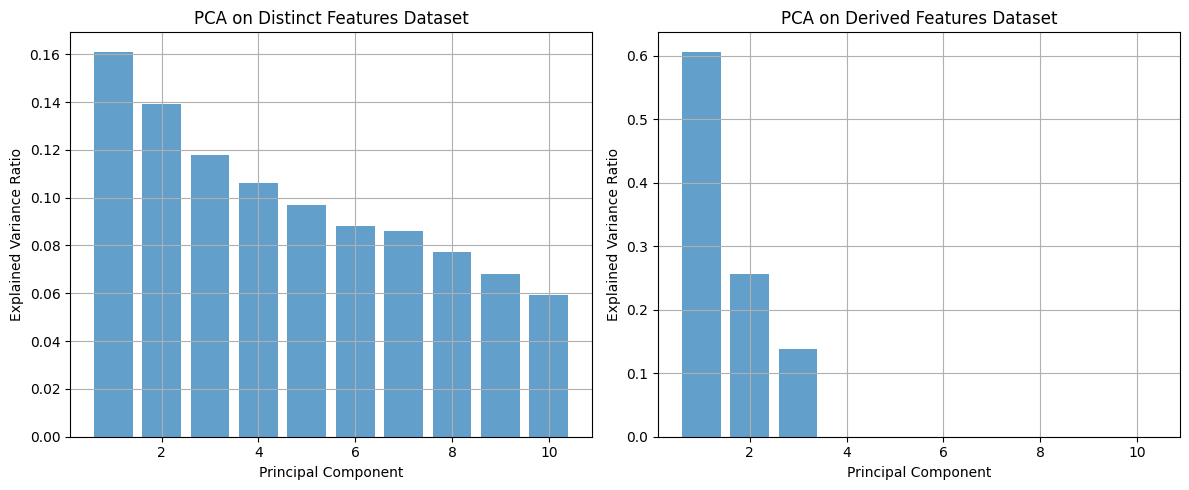

In [7]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(range(1, 11), pca1.explained_variance_ratio_, alpha=0.7, label='Distinct Features')
plt.title('PCA en dataframe sin variables relacionadas')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.bar(range(1, 11), pca2.explained_variance_ratio_, alpha=0.7, label='Linear Derived Features')
plt.title('PCA en dataframe con posible multicolinealidad')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)

plt.tight_layout()
plt.show()

In [8]:
# Transform data using PCA
data1_pca = pca1.transform(data1)
data2_pca = pca2.transform(data2)

# Convert to DataFrame with rounded values
data1_pca_df = pd.DataFrame(np.round(data1_pca, 4), columns=[f'PC_{i+1}' for i in range(data1_pca.shape[1])])
data2_pca_df = pd.DataFrame(np.round(data2_pca, 4), columns=[f'PC_{i+1}' for i in range(data2_pca.shape[1])])

print("Data proyectada del dataset 1:")
display(data1_pca_df.head())

print("\nData proyectada del dataset 2:")
display(data2_pca_df.head())

Projected Data for Dataset 1 (Distinct Features):


,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10
0,0.6044,-0.5568,0.0835,0.1620,0.0541,-0.2147,-0.2124,0.1161,-0.0541,0.1375
1,0.4541,-0.6159,-0.0458,-0.3648,0.0624,-0.1653,0.2667,-0.0849,0.0538,-0.1105
2,-0.2751,0.1893,-0.0607,-0.0626,-0.3589,-0.0545,-0.1984,-0.1692,-0.2878,-0.4061
3,-0.4411,0.7611,0.4437,0.0097,-0.0987,-0.2134,-0.2161,0.1185,-0.0070,-0.0441
4,-0.0645,0.1590,0.0614,-0.4867,-0.2921,-0.1220,-0.3135,0.0253,-0.2129,0.3079



Projected Data for Dataset 2 (Derived Features):


,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10
0,0.9163,-0.9112,-0.8696,0.0,0.0,0.0,-0.0,0.0,0.0,0.0
1,-1.5022,0.1080,0.7568,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0
2,-1.5397,0.8691,0.5875,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0
3,-0.3688,0.5345,0.6535,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0
4,0.2940,0.7131,0.7562,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0


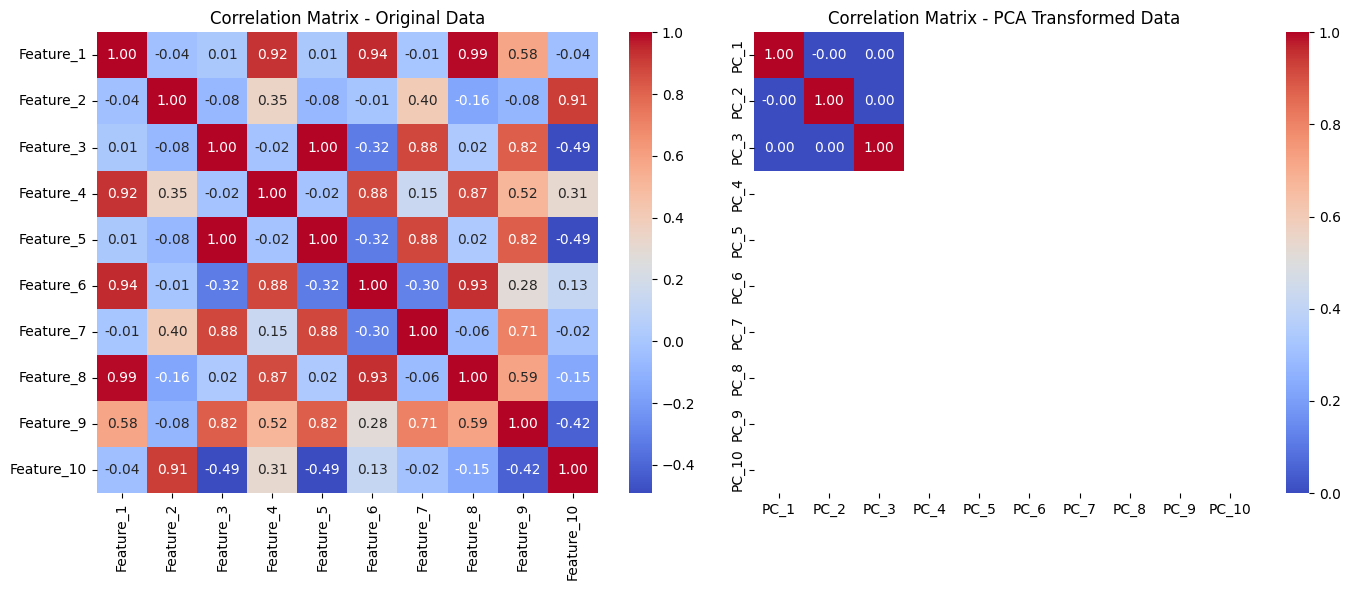

In [10]:
# Correlation Matrices
corr_original = data2.corr()      # Original data correlation
corr_pca = data2_pca_df.corr()    # PCA data correlation

# Visualization
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.heatmap(corr_original, cmap='coolwarm', annot=True, fmt=".2f", cbar=True)
plt.title("Correlation Matrix - Original Data")

plt.subplot(1, 2, 2)
sns.heatmap(corr_pca, cmap='coolwarm', annot=True, fmt=".2f", cbar=True)
plt.title("Correlation Matrix - PCA Transformed Data")

plt.tight_layout()
plt.show()

# 2. PCA en clasificación

Cargamos los datos y ajustamos los encabezados para entender el dataframe

In [80]:
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

In [81]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [82]:
variable_names = {
    0: 'class',
    1: 'Alcohol',
    2: 'Malicacid',
    3: 'Ash',
    4: 'Alcalinity_of_ash',
    5: 'Magnesium',
    6: 'Total_phenols',
    7: 'Flavanoids',
    8: 'Nonflavanoid_phenols',
    9: 'Proanthocyanins',
    10: 'Color_intensity',
    11: 'Hue',
    12: '0D280_0D315_of_diluted_wines',
    13: 'Proline',
}

data.rename(variable_names, axis=1, inplace=True)
data.head()

,class,Alcohol,Malicacid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,0D280_0D315_of_diluted_wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


Encontramos que tenemos 3 tipos de vino dentro de nuestros datos

In [83]:
data['class'].unique()

array([1, 2, 3])

In [84]:
x = data.drop('class', axis=1)
y = data['class']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=0)
x_train.head()

,Alcohol,Malicacid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,0D280_0D315_of_diluted_wines,Proline
84,11.84,0.89,2.58,18.0,94,2.20,2.21,0.22,2.35,3.05,0.79,3.08,520
11,14.12,1.48,2.32,16.8,95,2.20,2.43,0.26,1.57,5.00,1.17,2.82,1280
168,13.58,2.58,2.69,24.5,105,1.55,0.84,0.39,1.54,8.66,0.74,1.80,750
138,13.49,3.59,2.19,19.5,88,1.62,0.48,0.58,0.88,5.70,0.81,1.82,580
86,12.16,1.61,2.31,22.8,90,1.78,1.69,0.43,1.56,2.45,1.33,2.26,495


Finalmente, debido a que PCA es muy sensible a la escala de los datos, utilizaremos un objeto de la clase StandardScaler() para estandarizar el conjunto de datos.

In [85]:
scaler = StandardScaler()
x_train_std = scaler.fit_transform(x_train)
x_test_std = scaler.transform(x_test)

Una de las principales aplicaciones del algoritmo PCA consiste en la reducción de la dimensionalidad de un conjunto de datos para el entrenamiento de otros modelos, como clasificación o agrupación. En otras palabras, podemos disminuir la complejidad del problema, además de acelerar los tiempos de entrenamiento, sacrificando un poco de información al mantener solo una fracción de la varianza explicada.

Primero definiremos un objeto de la clase `PCA()`. Para poder graficar los resultados, vamos a definir un espacio de dos dimensiones (`n_components=2`).

Luego, al ser un problema de clasificación, definiremos un objeto de la clase `LogisticRegression()`. Tengamos en cuenta que utilizamos el esquema one-versus-rest (`multi_class='ovr'`) al tratarse de un problema multiclase:

In [86]:
pca = PCA(n_components=2)

In [87]:
logreg = LogisticRegression(multi_class='ovr', random_state=1)

In [88]:
x_train_pca = pca.fit_transform(x_train_std)
x_test_pca = pca.transform(x_test_std)

In [89]:
logreg.fit(x_train_pca, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.



LogisticRegression(multi_class='ovr', random_state=1)

En este punto puedes usar el atributo `components_` del objeto pca para obtener los ejes que representan las direcciones de máxima varianza en los datos. Cada componente es una combinación lineal de las variables originales, y la magnitud de sus elementos refleja la importancia de cada variable en la varianza explicada:

In [90]:
components = pca.components_
pd.DataFrame(components, columns=x_train.columns)

,Alcohol,Malicacid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,0D280_0D315_of_diluted_wines,Proline
0,0.146133,-0.241633,0.019224,-0.211617,0.137672,0.397291,0.421009,-0.299520,0.306022,-0.072659,0.325429,0.368392,0.301341
1,0.488911,0.202558,0.310203,-0.021697,0.303599,0.057907,-0.010570,0.078845,0.039143,0.545729,-0.219011,-0.213886,0.358218


Por otro lado, puedes usar el atributo `explained_variance_ratio_` para ver el porcentaje de varianza explicada por los componentes que definimos:

In [91]:
pca.explained_variance_ratio_

array([0.35950519, 0.18547258])

Por úlitmo, definiremos la función `plot_decision_regions()` para graficar el resultado de la clasificación, correspondientes a las regiones de decisión:

In [92]:
def plot_decision_regions(X, y, classifier, resolution=0.02):
    """
    Genera la gráfica con las regiones de decisión.

    Parámetros:
    X : pd.DataFrame
        Variables independientes del conjunto de datos.
    y : pd.DataFrame
        Variable objetivo del conjunto de datos.
    classifier : sklearn.linear_model.LogisticRegression
        Modelo de regresión logística entrenado.
    resolution : float
        Resolución utilizada para la definición de la grilla de predicciones.
    """
    # Se inicializan colores y formas de puntos.
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # Se obtienen los valores mínimo y máximo para los dos ejes
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    # Se genera una grilla con la resolución definida por parámetro
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    # Se realizan predicciones sobre cada punto de la grilla
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    # Se grafica un contorno coloreado utilizando la grilla y las predicciones
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    # Se definen los límites de la gráfica
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    # Se grafican los puntos del conjunto de datos
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.6,
                    color=cmap(idx),
                    marker=markers[idx],
                    label=cl)

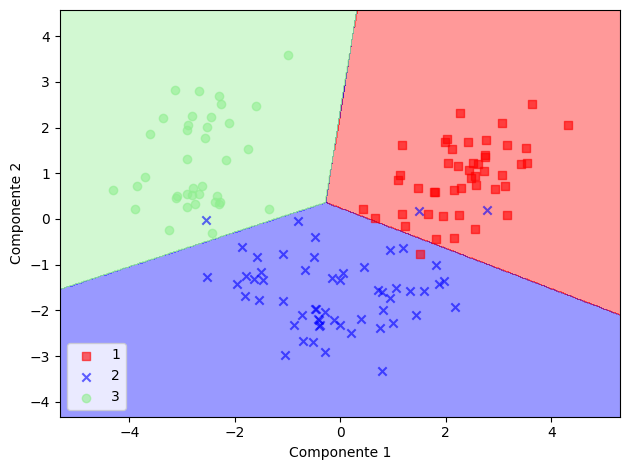

In [93]:
plot_decision_regions(x_train_pca, y_train, classifier=logreg)
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

# 3. PCA en imágenes + t-SNE

Cargamos nuestros datos a través de Kaggle

In [36]:
files.upload()
!ls -lha kaggle.json
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download zalando-research/fashionmnist

Saving kaggle.json to kaggle (1).json
-rw-r--r-- 1 root root 70 Apr 21 23:58 kaggle.json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
Dataset URL: https://www.kaggle.com/datasets/zalando-research/fashionmnist
License(s): other


In [38]:
ROOT_DIR = '/content'
DATASET_NAME = 'fashionmnist'

%cd {ROOT_DIR}
!unzip {DATASET_NAME}.zip -d {ROOT_DIR}/{DATASET_NAME}

/content
Archive:  fashionmnist.zip
  inflating: /content/fashionmnist/fashion-mnist_test.csv  
  inflating: /content/fashionmnist/fashion-mnist_train.csv  
  inflating: /content/fashionmnist/t10k-images-idx3-ubyte  
  inflating: /content/fashionmnist/t10k-labels-idx1-ubyte  
  inflating: /content/fashionmnist/train-images-idx3-ubyte  
  inflating: /content/fashionmnist/train-labels-idx1-ubyte  


In [46]:
train = pd.read_csv('/content/fashionmnist/fashion-mnist_train.csv', sep=',')
print(train.shape)
train.head()

(60000, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Este conjunto tiene una dimensionalidad de 784, ya que la última columna nos indica la clase. Para tener una visión más intuitiva de estas, crearemos un diccionario `class_names` utilizando la información del propio conjunto:

In [47]:
class_names = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

In [48]:
x_train = train.drop("label", axis=1)
y_train = train["label"]

Ahora veremos una muestra del conjunto de imágenes. Utilizaremos la función `reshape()` de `numpy` para convertir las filas de 784 elementos a una matriz de 28x28 elementos. Además, utilizaremos la función `imshow()` para mostrar las imágenes:

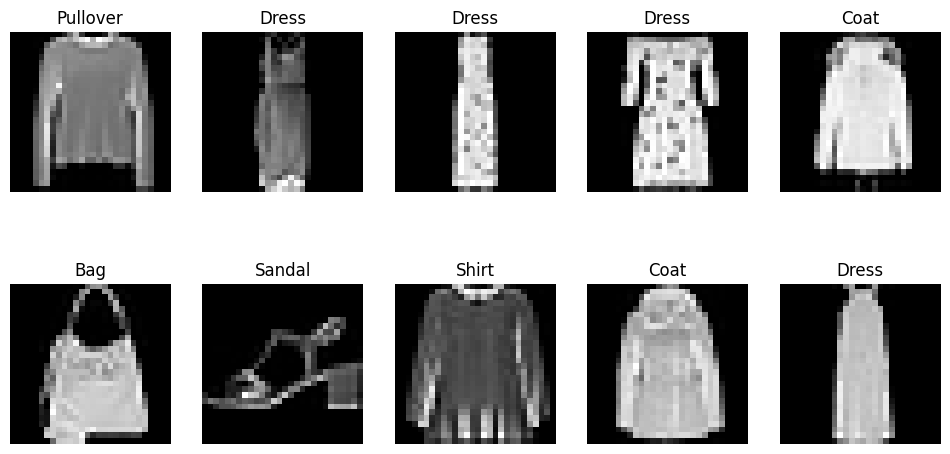

In [49]:
random_sample = np.random.randint(0, len(train) + 1, size=10)

plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train.iloc[random_sample[i]].values.reshape(28, 28), cmap='gray')
    plt.title(class_names[y_train[random_sample[i]]])
    plt.axis('off')
plt.show()

#### Selección de componentes principales:
Usualmente se busca seleccionar un número de componentes principales que permitan describir una gran parte de la varianza del conjunto de datos. Podemos utilizar dos métodos para realizar este proceso: un método gráfico y un método directo.

##### Método gráfico:

Al no especificar el número de componentes, `PCA()` mantiene todos los componentes. Utilizando el atributo `explained_variance_ratio_`, se retorna un arreglo de porcentajes de varianza explicada por cada componente, de forma que su suma es igual a 1. Si aplicamos la función de numpy `cumsum()`, obtendremos la suma acumulativa de estos porcentajes:

In [50]:
pca = PCA()
pca.fit(x_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
cumsum

array([0.29011353, 0.46739022, 0.52761721, 0.57731993, 0.61571282,
       0.65042278, 0.67386322, 0.6930026 , 0.70643865, 0.7195459 ,
       0.7294438 , 0.7385843 , 0.74623636, 0.75284063, 0.75893251,
       0.76484756, 0.77036802, 0.77567292, 0.7802725 , 0.78482785,
       0.78915608, 0.79321711, 0.7970518 , 0.80079401, 0.80441278,
       0.80792187, 0.81125773, 0.81444469, 0.81754088, 0.82049366,
       0.82325374, 0.82590714, 0.82853676, 0.83111356, 0.83358916,
       0.83597329, 0.83827404, 0.84051754, 0.84270881, 0.84480621,
       0.84681406, 0.84878978, 0.85073191, 0.85256967, 0.85432749,
       0.85604299, 0.8577235 , 0.85936274, 0.86098495, 0.86254533,
       0.86408496, 0.86559305, 0.86706937, 0.86849792, 0.86988167,
       0.87125196, 0.8725619 , 0.87385221, 0.87512278, 0.87638361,
       0.87761236, 0.87882023, 0.88000041, 0.88116388, 0.88231678,
       0.88343688, 0.88455181, 0.88564715, 0.88670744, 0.88775679,
       0.88879671, 0.88981931, 0.890793  , 0.8917484 , 0.89268

In [51]:
exp_var = 0.95

Graficamente podemos ver el arreglo `cumsum`, donde podremos ver el porcentaje de varianza explicada al tener una cantidad de componentes $k<=n$, donde n es el número de dimensiones original (en este caso 784). Aplicando la función `argmax()`, podemos obtener el índice en el que la varianza explicada alcanza el valor definido en `exp_var`:

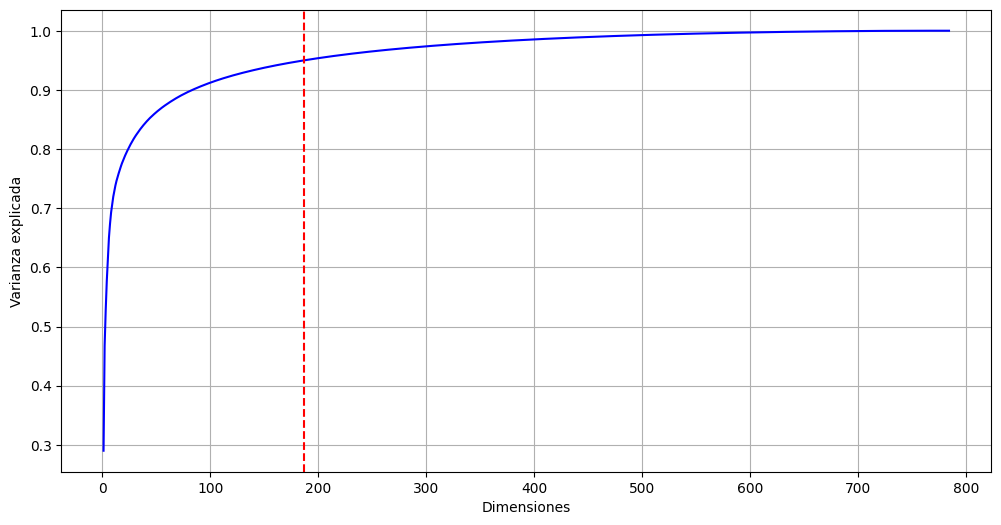

In [52]:
plt.figure(figsize=(12, 6))

x = np.arange(1,len(cumsum)+1)
d = np.argmax(cumsum >= exp_var) + 1

plt.plot(x, cumsum, linestyle='-', color='b')
plt.axvline(x=d, color='red', linestyle='--')

plt.xlabel('Dimensiones')
plt.ylabel('Varianza explicada')
plt.grid(True)
plt.show()

El número de dimensiones `d` que explica el 95% de la varianza es igual al índice + 1, es decir 187 dimensiones.

In [53]:
d

np.int64(187)

##### Método directo:

La clase `PCA()` permite definir el parámetro `n_components` como el número de componentes para mantener. Si el valor de `n_components` está entre 0 y 1, este valor representa el porcentaje de varianza explicada, en nuestro caso `exp_var` que hace referencia al 95%:

In [54]:
pca = PCA(n_components=exp_var)
x_reduced = pca.fit_transform(x_train)

Utilizando el atributo `n_components_`, podemos verificar que el número de componentes es el mismo obtenido con el método gráfico:

In [55]:
pca.n_components_

np.int64(187)

In [56]:
x_recovered = pca.inverse_transform(x_reduced)
x_recovered

array([[-5.07531154e-03, -3.49298819e-02, -1.82324169e-01, ...,
         7.14571702e+00,  1.30926258e+00,  1.95358272e-01],
       [ 5.81062833e-03, -6.77007913e-03,  2.84479415e-02, ...,
         2.05225124e+00,  6.46076155e-01,  9.19855854e-02],
       [-1.25425889e-02, -1.24573082e-02, -2.43415191e-02, ...,
        -3.66305222e+00,  7.47972492e-01, -2.46375309e-02],
       ...,
       [-3.49443398e-03,  1.11599311e-02, -1.66139031e-02, ...,
        -5.28212648e+00, -8.84199604e-01,  1.96516359e-02],
       [-8.19060309e-03, -6.30391178e-02,  2.35995112e-01, ...,
        -2.84203734e+00, -2.91067605e-01, -5.54467864e-01],
       [ 1.19488485e-03, -2.45043592e-02, -1.54126023e-01, ...,
         6.46512497e-01,  2.47597076e+00,  3.39597950e-01]])

Podemos comparar las imágenes recuperadas (reconstruidas) con las imágenes originales. Como podemos ver, las imágenes recuperadas son representaciones obtenidas a partir del 95% de la varianza almacenada al comprimir con PCA y descomprimir el resultado:

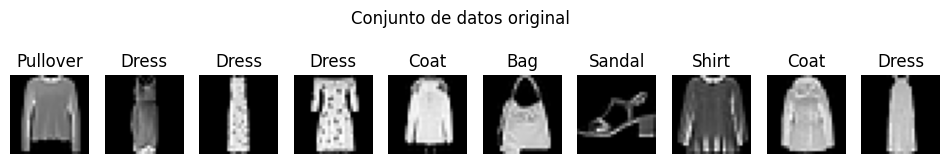

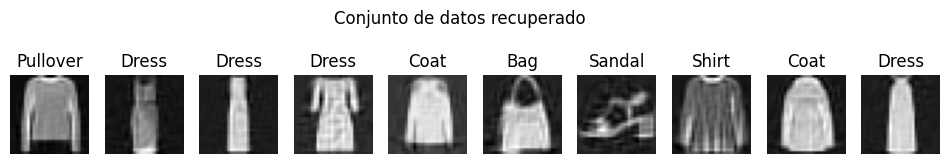

In [57]:
# Conjunto de datos original
fig1, axs1 = plt.subplots(1, 10, figsize=(12, 6), sharey=True)
for i in range(10):
    axs1[i].imshow(x_train.iloc[random_sample[i]].values.reshape(28, 28), cmap='gray')
    axs1[i].set_title(class_names[y_train[random_sample[i]]])
    axs1[i].axis('off')
fig1.suptitle("Conjunto de datos original")
fig1.subplots_adjust(top=1.5)

# Conjunto de datos recuperado
fig2, axs2 = plt.subplots(1, 10, figsize=(12, 6), sharey=True)
for i in range(10):
    axs2[i].imshow(x_recovered[random_sample[i]].reshape(28, 28), cmap='gray')
    axs2[i].set_title(class_names[y_train[random_sample[i]]])
    axs2[i].axis('off')
fig2.suptitle("Conjunto de datos recuperado")
fig2.subplots_adjust(top=1.5)

#### t-SNE con parámetros por defecto
A continuación, aplicaremos el algoritmo t-SNE sobre el conjunto reducido `x_reduced` generado en el método directo, convirtiendo el resultado en un DataFrame. Por defecto, la clase `TSNE()` retorna una representación de dos dimensiones:

In [60]:
tsne = TSNE(random_state=0, verbose=1)
x_tsne = pd.DataFrame(tsne.fit_transform(x_reduced))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 60000 samples in 0.015s...
[t-SNE] Computed neighbors for 60000 samples in 66.028s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 12000 / 60000
[t-SNE] Computed conditional probabilities for sa

Finalmente, utilizaremos el resultado almacenado en `x_tsne` para obtener una gráfica en dos dimensiones. Si usamos la variable objetivo para agrupar los elementos, también tendremos más información sobre la distribución de las clases en el espacio:

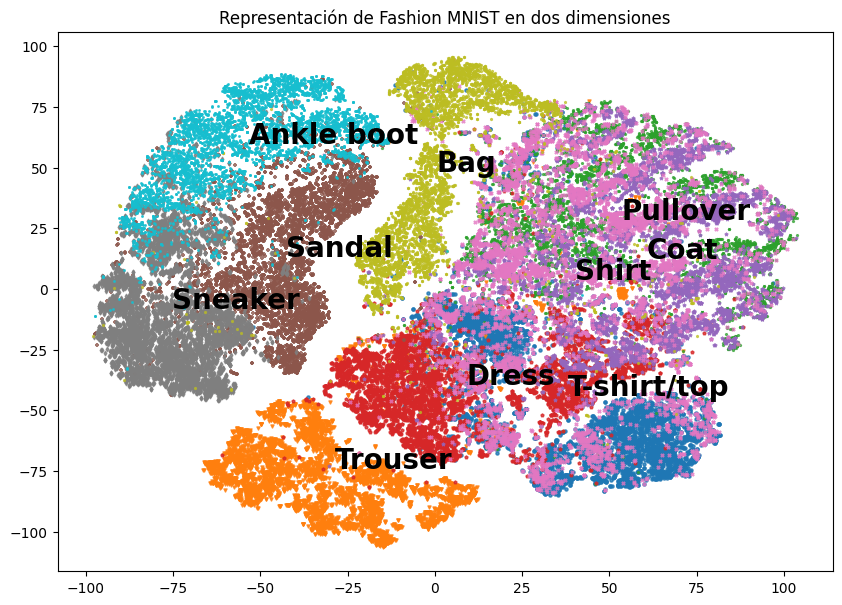

In [61]:
MARKER = ['o', 'v', '1', 'p' ,'*', '+', 'x', 'd', '4', '.']
plt.figure(figsize=(10, 7))
plt.title('Representación de Fashion MNIST en dos dimensiones');
for i in range(10):
    selections = x_tsne.iloc[y_train[y_train==i].index]
    plt.scatter(selections[0], selections[1], alpha=0.8, marker=MARKER[i], s=5)
    x, y = selections.mean(axis=0)
    plt.text(x, y, str(class_names[i]), fontdict={'weight': 'bold', 'size': 20})
plt.show()

La perplejidad (parámetro `perplexity`) es un hiperparámetro de t-SNE que relaciona el número de vecinos más cercanos utilizado en el entrenamiento. En el caso anterior utilizamos el valor por defecto de **30**, aunque usualmente se recomienda un valor entre 5 y 50. Veremos el resultado al utilizar un valor más bajo:

In [62]:
tsne = TSNE(perplexity=5, random_state=0, verbose=1)
x_tsne = pd.DataFrame(tsne.fit_transform(x_reduced))

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 60000 samples in 0.009s...
[t-SNE] Computed neighbors for 60000 samples in 62.960s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 12000 / 60000
[t-SNE] Computed conditional probabilities for sa

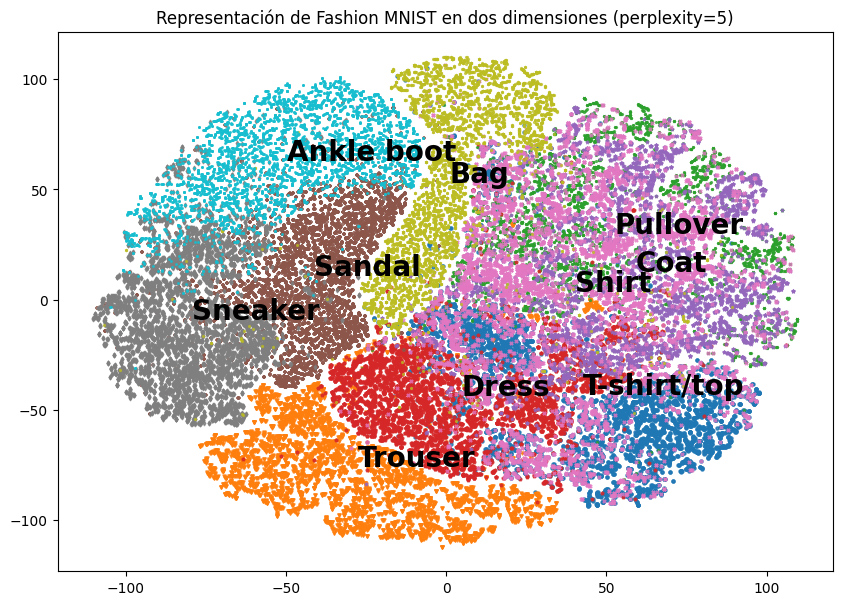

In [63]:
plt.figure(figsize=(10, 7))
plt.title('Representación de Fashion MNIST en dos dimensiones (perplexity=5)');
for i in range(10):
    selections = x_tsne.iloc[y_train[y_train==i].index]
    plt.scatter(selections[0], selections[1], alpha=0.8, marker=MARKER[i], s=5)
    x, y = selections.mean(axis=0)
    plt.text(x, y, str(class_names[i]), fontdict={'weight': 'bold', 'size': 20})
plt.show()